# Introduction

Multi-modal embedding with Azure AI Foundry MaaS, `Cohere-embed-v3-multilingual` for text and image embedding.

### Reference
* https://ai.azure.com
* image embedding example https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/ai/azure-ai-inference/samples/sample_image_embeddings.py
* text embedding example (multi lingual) https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/ai/azure-ai-inference/samples/sample_embeddings.py

In [1]:
from dotenv import dotenv_values
import requests
from PIL import Image
from io import BytesIO

import os
from azure.ai.inference import EmbeddingsClient, ImageEmbeddingsClient
from azure.ai.inference.models import ImageEmbeddingInput, EmbeddingItem, EmbeddingsResult
from azure.core.credentials import AzureKeyCredential
from embed_util import EmbedResult

config = {
    **dotenv_values("./envs/foundrymaas.env")
}

endpoint = config["AZURE_INFERENCE_ENDPOINT"]
key = config["AZURE_INFERENCE_KEY"]
model = config["MODEL_NAME"]

# use "" to avoid acidentally output the config variable in notebook cells
""

''

### Embed Image

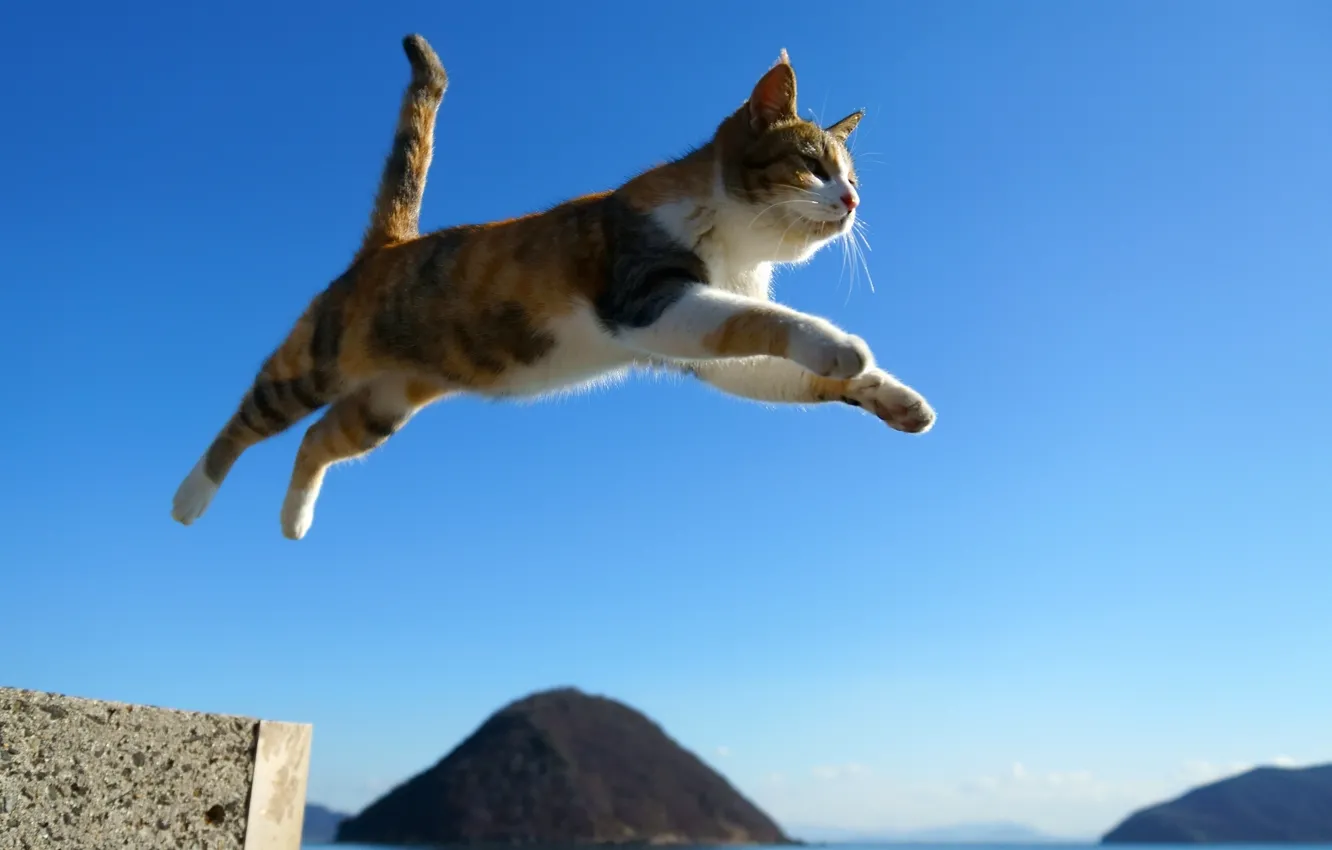

In [2]:
url = "https://img1.goodfon.com/wallpaper/nbig/6/2b/kot-koshka-pryzhok.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Albert_Einstein_1921_by_F_Schmutzer.jpg/500px-Albert_Einstein_1921_by_F_Schmutzer.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))

data_path = os.path.join(os.getcwd(), "data")

# do not overwrite existing files
if not os.path.exists(data_path):
    os.makedirs(data_path)

img_file_path = os.path.join(data_path, "cat.jpg")
if not os.path.exists(img_file_path):
    # Save the image to the local file system
    img.save(img_file_path)

# Display the image in the notebook
display(img)

# Open in a new window (if needed)
# img.show()


In [3]:
img_embed = ImageEmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

img_embed_input = ImageEmbeddingInput.load(image_file=img_file_path, image_format="jpeg")

img_response = img_embed.embed(
    input=[img_embed_input],
    model=model,
)

In [4]:
# multiple images embedding possible
# for item in response.data:
#     print(f"type(item)={type(item)}")
#     length = len(item.embedding)
#     print(
#         f"data[{item.index}]: length={length}, [{item.embedding[0]}, {item.embedding[1]}, "
#         f"..., {item.embedding[length-2]}, {item.embedding[length-1]}]"
#     )

In [5]:
def parse_embed_result(response: EmbeddingsResult, model=None, idx=0) -> EmbedResult:
    """parse the embedding result for response by given index"""
    if response.data is not None:
        item = response.data[idx]
        if isinstance(item, EmbeddingItem):
            return EmbedResult({
                "modelVersion": model,
                "vector":item.embedding
            })
    return None

In [6]:
img_embed_result = parse_embed_result(img_response, model=model, idx=0)
img_embed_result

EmbedResult(model_version=Cohere-embed-v3-multilingual, vector=[-0.057403564,-0.010719299,-0.01725769,...], size=1024, error=None)

### Embed text (multi lingual)

In [7]:
text_en = "cat jumping"

embed_text = EmbeddingsClient(
    endpoint=endpoint,
    credential=AzureKeyCredential(key)
)

text_response_en = embed_text.embed(
    input=[text_en],
    model=model,
)

In [8]:
text_embed_result_en = parse_embed_result(text_response_en, model=model, idx=0)
text_embed_result_en

EmbedResult(model_version=Cohere-embed-v3-multilingual, vector=[0.010917664,0.0036716461,-0.0010128021,...], size=1024, error=None)

In [9]:
img_text_sim_en = img_embed_result.relevance_score(text_embed_result_en)
img_text_sim_en

0.7166916318194237

In [10]:
text_de = "katze springt"

text_response_de = embed_text.embed(input=[text_de], model=model)
text_embed_result_de = parse_embed_result(text_response_de, model=model, idx=0)

text_embed_result_de

EmbedResult(model_version=Cohere-embed-v3-multilingual, vector=[0.044555664,0.051818848,-0.02810669,...], size=1024, error=None)

In [11]:
# Image to text similarity
img_text_sim_de = img_embed_result.relevance_score(text_embed_result_de)
img_text_sim_de

0.642165390996317

In [12]:
# compare the two similarity scores for both languages
img_text_sim_en, img_text_sim_de

(0.7166916318194237, 0.642165390996317)

In [13]:
text_dog_en = "dog eating"

text_response_dog_en = embed_text.embed(input=[text_dog_en], model =model)
text_embed_dog_en = parse_embed_result(text_response_dog_en, model=model, idx=0)

text_embed_dog_en

EmbedResult(model_version=Cohere-embed-v3-multilingual, vector=[-0.04006958,0.0032234192,0.0090408325,...], size=1024, error=None)

In [14]:
img_text_unsim_en = img_embed_result.relevance_score(text_embed_dog_en)
img_text_unsim_en

0.3728697545276229

In [15]:
# compare the two similarity scores for both languages, and unsimilar score for dog text and cat image
img_text_sim_en, img_text_sim_de, img_text_unsim_en

(0.7166916318194237, 0.642165390996317, 0.3728697545276229)